### 12 parameter model: 
NMF-based SFH (4 params), starburst (2 params), metallicity (1 param), dust (2 optical depths and 1 slope), stellar mass (1 param), redshift (1 param)

See `script/NMF/gen_sed_nmf.py` for details.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
sys.path.append('/home/jiaxuanl/Research/Packages/exspect/')

In [3]:
import fsps
import sedpy
from sedpy.observate import load_filters
import prospect
from prospect.sources.constants import cosmo #WMAP9
import exspect

In [4]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [5]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

In order to cover SDSS five bands, we need spectrum covering 1000 A to 60,000 A. But we split the wavelength range into several pieces: `'.w1000_2000', '.w2000_3600', '.w3600_5500', '.w5500_7410', '.w7410_60000'`


Let's sample the prior, instead of doing a grid search.

IMF: Chabrier (2003) (in FSPS, imf=1)

$\beta_i \sim \rm Dirichlet$ (NMF coeffs)

$\log Z [Z_\odot] \sim \rm Uniform[-2.6, 0.3]$ (this limit is set by the metallicity of MILES library)

$\log\, M_\star\ [M_\odot] = 0.0$

$z \sim \rm Uniform[0, 1]$ (this is only used to calculte `tage`, i.e., the length of SFH).

$\tau_1 \sim \rm Uniform[0, 3],\ \tau_2 \sim \rm Uniform[0, 3],\ \tau_{\rm slope} \sim \rm Uniform[-3, 1]$. (See Conroy09a)


**Therefore, the `speculator` bounds should be exactly the same as above.**

### Some test code

In [6]:
from popsed import prior, models

In [7]:
model = models.NMF_ZH(burst=True, peraa=True)
model._ssp_initiate() # slow

# wavelength range set to cover GALEX FUV to WISE W2
w_fsps = model._ssp.wavelengths
wmin, wmax = 1000., 60000.
wlim = (w_fsps >= wmin) & (w_fsps <= wmax)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [8]:
model._ssp.__dict__

{'params': <fsps.fsps.ParameterSet at 0x14e7b03c8910>,
 '_zcontinuous': 1,
 '_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
        1.000e+08]),
 '_emwavelengths': None,
 '_zlegend': None,
 '_ssp_ages': None,
 '_stats': None,
 '_libraries': None}

In [12]:
params = model._ssp.params

In [13]:
model._ssp.params.__dict__

{'dirtiness': 2,
 '_params': {'add_agb_dust_model': True,
  'add_dust_emission': True,
  'add_igm_absorption': False,
  'add_neb_emission': False,
  'add_neb_continuum': True,
  'add_stellar_remnants': True,
  'redshift_colors': False,
  'compute_light_ages': False,
  'nebemlineinspec': True,
  'smooth_velocity': True,
  'smooth_lsf': False,
  'cloudy_dust': False,
  'agb_dust': 1.0,
  'tpagb_norm_type': 2,
  'dell': 0.0,
  'delt': 0.0,
  'redgb': 1.0,
  'agb': 1.0,
  'fcstar': 1.0,
  'fbhb': 0.0,
  'sbss': 0.0,
  'pagb': 1.0,
  'zred': 0.0,
  'zmet': 1,
  'logzsol': 0.0,
  'pmetals': 2.0,
  'imf_type': 1,
  'imf_upper_limit': 120,
  'imf_lower_limit': 0.08,
  'imf1': 1.3,
  'imf2': 2.3,
  'imf3': 2.3,
  'vdmc': 0.08,
  'mdave': 0.5,
  'evtype': -1,
  'masscut': 150.0,
  'sigma_smooth': 0.0,
  'min_wave_smooth': 1000.0,
  'max_wave_smooth': 10000.0,
  'gas_logu': -2,
  'gas_logz': 0.0,
  'igm_factor': 1.0,
  'sfh': 0,
  'tau': 1.0,
  'const': 0.0,
  'sf_start': 0.0,
  'sf_trunc': 0.0,


In [14]:
ncomp = 4
priors = prior.load_priors([
        # Log stellar mass, in M_sun
        prior.UniformPrior(0.0, 0.0, label='logmstar'),
        # flat dirichilet priors for SFH
        prior.FlatDirichletPrior(ncomp, label='beta'),
        # uniform priors on the mass fraction of burst
        prior.UniformPrior(0, 0.8, label='fburst'),
        # uniform priors on star-burst lookback time
        prior.UniformPrior(1e-2, 13.27, label='tburst'),
        # log uniform priors on metallicity history
        prior.LogUniformPrior(4.5e-5, 4.5e-2, label='gamma1_zh'),
        prior.LogUniformPrior(4.5e-5, 4.5e-2, label='gamma2_zh'),
        # uniform priors on dust1
        prior.UniformPrior(0., 3., label='dust1'),
        # uniform priors on dust2
        prior.UniformPrior(0., 3., label='dust2'),
        # uniform priors on dust_index
        prior.UniformPrior(-3., 1., label='dust_index'),
        # uniformly sample redshift
        prior.UniformPrior(0., 1.5, label='redshift')
    ])

##### We show an example of how to generate spectrum for a given set of params, and calculte the magnitudes, which confuses me for many times

In [15]:
N_samples = 1 # generate 1 spectrum
tt = np.array([priors.transform(priors.sample()) for i in range(N_samples)])
tage = model.cosmo.age(tt[:, -1:]).value # convert redshift to age
theta = model._parse_theta(tt[:, :-1])

In [16]:
tage, theta

(array([[6.44116832]]),
 {'logmstar': array([0.]),
  'beta1_sfh': array([0.46769492]),
  'beta2_sfh': array([0.01149777]),
  'beta3_sfh': array([0.01284232]),
  'beta4_sfh': array([0.507965]),
  'fburst': array([0.79423229]),
  'tburst': array([7.99537887]),
  'gamma1_zh': array([0.00036863]),
  'gamma2_zh': array([0.00043108]),
  'dust1': array([2.43281346]),
  'dust2': array([1.52453447]),
  'dust_index': array([-0.6654619])})

Text(0, 0.5, 'SFR [Msun/yr] (normalized to 1 Msun)')

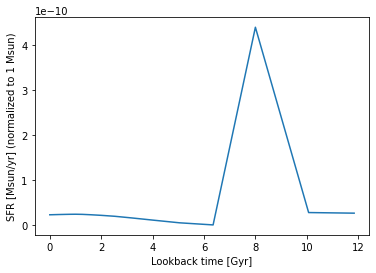

In [17]:
# Display SFH
tlb_edges, sfh = model.SFH(np.hstack([np.zeros(len(tt))[:, None], tt[:, 1:-1]]), zred=0.1, _burst=True)
plt.plot(0.5 * (tlb_edges[1:] + tlb_edges[:-1]), sfh)
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [Msun/yr] (normalized to 1 Msun)')

Text(0, 0.5, 'ZH')

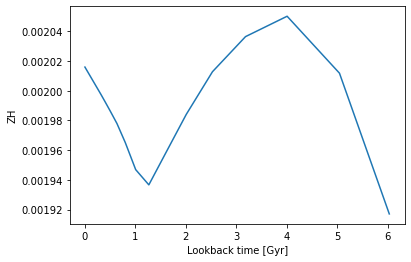

In [18]:
# Display SFH
tlb_edges, zh = model.ZH(tt[:, :-1], zred=float(tt[:, -1]))
plt.plot(0.5 * (tlb_edges[1:] + tlb_edges[:-1]), zh)
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('ZH')

In [19]:
np.log10(model.Z_MW(tt[:, :-1], zred=float(tt[:, -1])) / 0.019)

array([-0.97865477])

In [20]:
tt[:, -1]

array([0.86755716])

In [21]:
# Generate spectrum, slow
wave, lum_ssp = model._sps_model(tt[0, :-1], 4.2777569)

In [22]:
model._ssp.params.__dict__

{'dirtiness': 0,
 '_params': {'add_agb_dust_model': True,
  'add_dust_emission': True,
  'add_igm_absorption': False,
  'add_neb_emission': False,
  'add_neb_continuum': True,
  'add_stellar_remnants': True,
  'redshift_colors': False,
  'compute_light_ages': False,
  'nebemlineinspec': True,
  'smooth_velocity': True,
  'smooth_lsf': False,
  'cloudy_dust': False,
  'agb_dust': 1.0,
  'tpagb_norm_type': 2,
  'dell': 0.0,
  'delt': 0.0,
  'redgb': 1.0,
  'agb': 1.0,
  'fcstar': 1.0,
  'fbhb': 0.0,
  'sbss': 0.0,
  'pagb': 1.0,
  'zred': 0.0,
  'zmet': 1,
  'logzsol': -0.9671220321105344,
  'pmetals': 2.0,
  'imf_type': 1,
  'imf_upper_limit': 120,
  'imf_lower_limit': 0.08,
  'imf1': 1.3,
  'imf2': 2.3,
  'imf3': 2.3,
  'vdmc': 0.08,
  'mdave': 0.5,
  'evtype': -1,
  'masscut': 150.0,
  'sigma_smooth': 0.0,
  'min_wave_smooth': 1000.0,
  'max_wave_smooth': 10000.0,
  'gas_logu': -2,
  'gas_logz': 0.0,
  'igm_factor': 1.0,
  'sfh': 0,
  'tau': 1.0,
  'const': 0.0,
  'sf_start': 0.0,
  '

In [432]:
model._tage_z_interp(redshift)

array(4.2777569)

In [429]:
tt[0, :-1], tage[0]

(array([ 0.00000000e+00,  9.49023809e-01,  6.17125308e-03,  3.40702206e-02,
         1.07347171e-02,  2.80365388e-01,  1.11506440e+00,  8.62215235e-03,
         4.78234990e-04,  4.53016960e-01,  1.42580848e+00, -8.70567961e-01]),
 array([11.99653519]))

In [401]:
print('The spectrum is in unit of Lsun/AA') if model._peraa else print('The spectrum is in unit of Lsun/Hz')

The spectrum is in unit of Lsun/AA


In [434]:
np.save('./test.npy', np.vstack([wave, lum_ssp]))

## Now we study how to calculate mags and redshift a spectrum

In [435]:
wave, lum_ssp = np.load('./test.npy') # this is already per aa
wave = wave[wlim]
lum_ssp = lum_ssp[wlim]
spec = lum_ssp * to_cgs_at_10pc

In [436]:
from popsed.models import lightspeed, to_cgs_at_10pc

In [437]:
redshift = 1.5

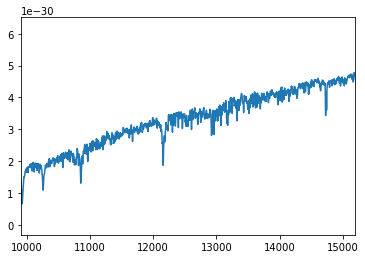

In [438]:
temp = model.sed(tt[0, :-1], redshift, wavelength=wave)

In [439]:
tt[0, :-1], tage[0]

(array([ 0.00000000e+00,  9.49023809e-01,  6.17125308e-03,  3.40702206e-02,
         1.07347171e-02,  2.80365388e-01,  1.11506440e+00,  8.62215235e-03,
         4.78234990e-04,  4.53016960e-01,  1.42580848e+00, -8.70567961e-01]),
 array([11.99653519]))

In [384]:
from popsed.speculator import SuperSpeculator, StandardScaler
name = 'NMF_ZH'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy'), 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh', 
                 'dust1', 'dust2', 
                 'dust_index', 'redshift'],  # , 'logm'
    device='cuda')

In [385]:
import torch

In [440]:
t_spec = torch.Tensor(np.repeat(spec[None, :], 2, axis=0)).to('cuda')
t_redshift = torch.Tensor(np.array([[redshift], [redshift]])).to('cuda')

In [441]:
my_z_spec = speculator.transform(t_spec, t_redshift, islog=False).detach().cpu().numpy()

(1000.0, 15000.0)

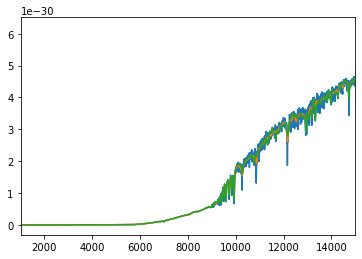

In [442]:
temp = model.sed(tt[0, :-1], redshift, wavelength=wave)
plt.plot(temp[0], temp[1])
plt.plot(wave, my_z_spec[0])

plt.xlim(1000, 15000)

In [443]:
w_z = wave * (1. + redshift)
d_lum = model._d_lum_z_interp(redshift)
flux_z = lum_ssp * 3.846e33 / (4. * np.pi * d_lum**2) / (1. + redshift)  # 1 ergs/s/cm^2/Ang

3.846e33 # solar luminosity in erg

In [444]:
import popsed

In [445]:
resampflux = popsed.utils.trapz_rebin(
                        w_z, flux_z, xnew=wave[(wave < 15000) & (wave > 3000)])

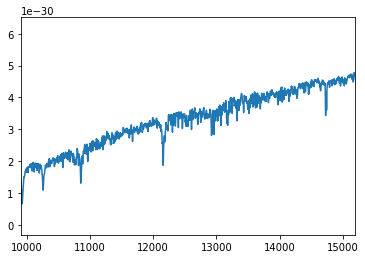

In [446]:
temp = model.sed(tt[0, :-1], redshift, wavelength=wave[(wave < 15000) & (wave > 3000)])

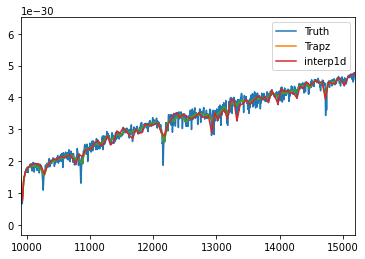

In [447]:
plt.plot(w_z, flux_z, label='Truth')

plt.plot(wave[(wave < 15000) & (wave > 3000)], resampflux, label='Trapz')

plt.plot(temp[0], temp[1])

plt.plot(wave, my_z_spec[0], label='interp1d')

plt.xlim(9900, 15200)

# plt.ylim(0.2e-30, 3e-30)

plt.legend()

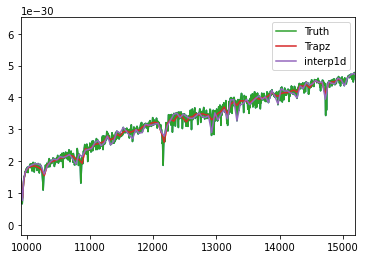

In [453]:
temp = model.sed(tt[0, :-1], redshift, wavelength=wave[(wave < 15000) & (wave > 3000)])
plt.plot(temp[0], temp[1])
ax = plt.gca()

plt.plot(w_z, flux_z, label='Truth')

plt.plot(wave[(wave < 15000) & (wave > 3000)], resampflux, label='Trapz')

plt.plot(wave, my_z_spec[0], label='interp1d')

# plt.xlim(9900, 15200)

# plt.ylim(0.2e-30, 3e-30)

plt.legend()

In [169]:
### Just linear interpolate

from scipy.interpolate import interp1d

In [195]:
f = interp1d(w_z, flux_z, bounds_error=False, fill_value=0, kind='cubic')

In [190]:
f(wave)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       6.99894557e-30, 6.91469740e-30, 6.83110547e-30])

In [199]:
from scipy.integrate import quad, trapezoid

In [204]:
quad(f, 3000, 8000)

(1.4224512593017748e-25, 5.202104609608003e-26)

In [220]:
flag = (w_z < 8000) & (w_z > 3000)
trapezoid(flux_z[flag], w_z[flag],)

1.441010003304552e-25

In [219]:
flag = (temp[0] < 8000) & (temp[0] > 3000)
trapezoid(temp[1][flag] * 1e-17, temp[0][flag],)

1.4938868221047269e-25

In [222]:
1.49 / 1.44

1.0347222222222223

In [216]:
flag = (wave < 8000) & (wave > 3000)
trapezoid(f(wave)[flag], wave[flag])

1.4334350148481002e-25

In [217]:
flag = (wave < 8000) & (wave > 3000)
trapezoid(my_z_spec[0][flag], wave[flag])

1.433638368590364e-25

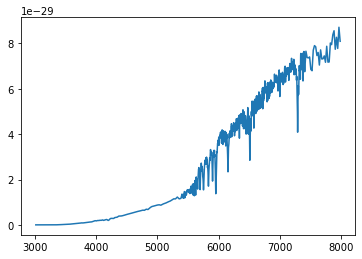

In [218]:
plt.plot( wave[flag], my_z_spec[0][flag])

In [ ]:
plt.plot(wave, f(wave))

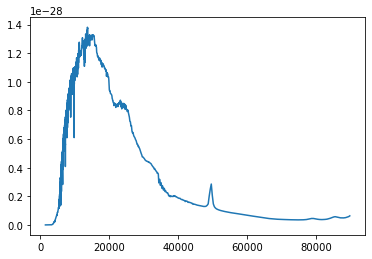

In [201]:
plt.plot(w_z, flux_z)

In [ ]:
flux_z = lum_ssp * 3.846e50 / \
                (4. * np.pi * d_lum**2) / (1. + _zred)  # 10^-17 ergs/s/cm^2/Ang

In [62]:
wave_rest, lum_ssp = model._sps_model(tt[0, :-1], model._tage_z_interp(tt[0, -1]))
flag = (wave_rest <= 60000) & (wave_rest >= 1000)
wave_rest = wave_rest[flag]
lum_ssp = lum_ssp[flag] ## this lum_ssp is just my pickled spec

In [ ]:
w_z = wave_rest * (1. + _zred)

In [ ]:
temp = model.sed(tt[0, :-1], redshift, wavelength=wave)
wave_rest, lum_ssp = model._sps_model(tt[0, :-1], model._tage_z_interp(redshift))


We can convert spectrum in Lsun/Hz to Lsun/AA by $$f_\lambda = \frac{c}{\lambda^2} f_\nu.$$ Notice that `c = 3e18 AA/s`.

In [240]:
# some constants
lsun = 3.846e33  # erg/s
pc = 3.085677581467192e18  # in cm
lightspeed = 2.998e18  # AA/s
ckms = 2.998e5  # km/s
jansky_mks = 1e-26
jansky_cgs = 1e-23
# value to go from L_sun/AA to erg/s/cm^2/AA at 10pc
to_cgs_at_10pc = lsun / (4.0 * np.pi * (pc * 10)**2)

In [241]:
spec_aa = spec * lightspeed / wave**2

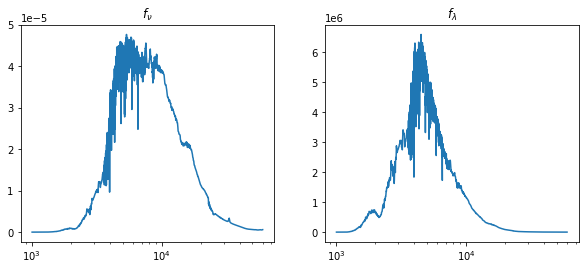

In [242]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(wave, spec)
axes[0].set_title(r'$f_\nu$')
axes[0].set_xscale('log')
axes[1].plot(wave, spec_aa)
axes[1].set_title(r'$f_\lambda$')
axes[1].set_xscale('log')

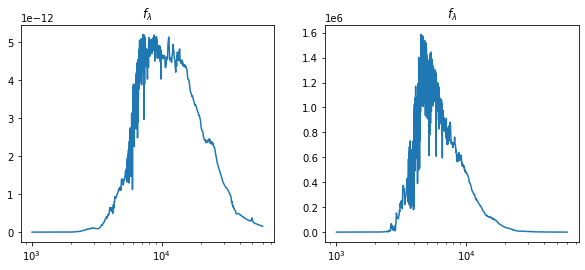

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# axes[0].plot(temp[0], temp[1])
axes[0].plot(temp[0], temp[1] * lightspeed / temp[0]**2)
axes[0].set_title(r'$f_\lambda$')
axes[0].set_xscale('log')
axes[1].plot(wave, spec_aa)
axes[1].set_title(r'$f_\lambda$')
axes[1].set_xscale('log')

Now we calculate the absolute magnitudes of this spectrum, i.e., we place this galaxy at 10 pc, then multiply the transmission curves of filters to the spectrum. We need to work on `spec_aa` for this purpose.

`to_cgs_at_10pc` is used to convert luminosity density Lsun/AA to erg/s/cm^2/AA at 10 pc.

We don't need to worry about the zeropoint and how to convert 3631 Jy (1 Jy = 1e-23 erg/s/cm^2/Hz). `sedpy` does that for us.

In [159]:
### Calculate transmission curves at grid of `wave`
from sedpy import observate
from scipy.interpolate import interp1d
x = wave
filterset = [f'sdss_{filt}0' for filt in 'ugriz']

# transmission efficiency
_epsilon = np.zeros((len(filterset), len(x)))
_zero_counts = np.zeros(len(filterset))
filters = observate.load_filters(filterset)
for i in range(len(filterset)):
    _epsilon[i] = interp1d(filters[i].wavelength,
                           filters[i].transmission, 
                           bounds_error=False,
                                   fill_value=0)(x)
    _zero_counts[i] = filters[i].ab_zero_counts
filterset = filterset
transmission_effiency = _epsilon
ab_zero_counts = _zero_counts

In [160]:
ab_zero_counts

array([0.00182001, 0.00952707, 0.00945654, 0.00635115, 0.00105704])

In [161]:
# Now manually integration over transmisison curves
dfactor = 1 # distance dimming fractor, equals to 1.0 at 10 pc

maggies = np.trapz(
    (wave * spec_aa * to_cgs_at_10pc / dfactor)[None, :] * transmission_effiency[None, :]
     , wave) / ab_zero_counts

-2.5 * np.log10(maggies) # absolute magnitudes

array([[8.16039319, 6.50369357, 5.79714474, 5.41885356, 5.05851919]])

---
### Play with redshfit

If you need to calculate the apparent magnitude of this galaxy at a given redshift, additional redshift effect should be added. The `dfactor` becomes `dfactor = ((distances [Mpc] * 1e5)**2 / (1 + z))`.

$$f_{\lambda_0} d \lambda_0 = f_{\lambda_1} d \lambda_1 = (1+z) f_{\lambda_0 (1+z)} d \lambda_0$$

$$f_{\lambda_o} d \lambda_o = \frac{1}{1+z} f_{\lambda_o/(1+z)} d \lambda_o$$

In [243]:
redshift = 0.5

In [288]:
_wave = wave * (1 + redshift)
_spec = interp1d(_wave, spec, bounds_error=False, kind='cubic', fill_value=0)(wave) / (1 + redshift) * to_cgs_at_10pc
dfactor = ((cosmo.luminosity_distance(redshift) * 1e5)**2).value
_spec /= dfactor
# _spec is a function of `wave`, where `wave` is actually the observation frame

In [289]:
temp = model.sed(tt[0, :-1], redshift, wavelength=wave)
wave_rest, lum_ssp = model._sps_model(tt[0, :-1], model._tage_z_interp(redshift))
w_z = wave_rest * (1 + redshift)
d_lum = model._d_lum_z_interp(redshift)
flux_z = lum_ssp * 3.846e33 / (4. * np.pi * d_lum**2) / (1. + redshift)  # 1 ergs/s/cm^2/Ang

(0.0, 10000.0)

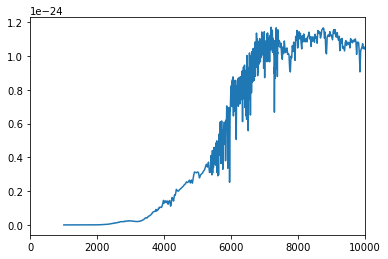

In [290]:
plt.plot(temp[0], temp[1] * 1e-13)
plt.xlim(0, 10000)

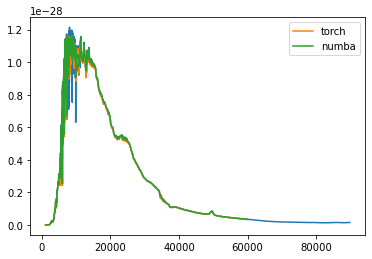

In [292]:
plt.plot(w_z[wlim], flux_z[wlim])
plt.plot(wave, _spec, label='torch')

plt.plot(temp[0], temp[1] * 1e-17, label='numba')

# plt.xlim(7000, 7800)

plt.legend()


In [184]:
### Calculate transmission curves at grid of `wave`
from sedpy import observate
from scipy.interpolate import interp1d
x = wave
filterset = [f'sdss_{filt}0' for filt in 'ugriz']

# transmission efficiency
_epsilon = np.zeros((len(filterset), len(x)))
_zero_counts = np.zeros(len(filterset))
filters = observate.load_filters(filterset)
for i in range(len(filterset)):
    _epsilon[i] = interp1d(filters[i].wavelength,
                           filters[i].transmission, 
                           bounds_error=False,
                                   fill_value=0)(x)
    _zero_counts[i] = filters[i].ab_zero_counts
filterset = filterset
transmission_effiency = _epsilon
ab_zero_counts = _zero_counts

In [210]:
from astropy.cosmology import FlatLambdaCDM, Planck15
cosmo = Planck15#FlatLambdaCDM(71.9, 0.3)

In [99]:
# Now manually integration over transmisison curves
dfactor = ((cosmo.luminosity_distance(redshift) * 1e5)**2).value
# distance dimming fractor

maggies = np.trapz(
    (wave * _spec / dfactor)[None, :] * transmission_effiency[None, :]
     , wave) / ab_zero_counts

-2.5 * np.log10(maggies) # absolute magnitudes

array([[46.49855608, 45.07940401, 44.39854688, 44.0063427 , 43.66649516]])

In [100]:
model._ssp.get_mags(tage=tage, redshift=redshift, bands=[f'sdss_{filt}' for filt in 'ugriz'])

array([46.49970434, 45.08041556, 44.39942831, 44.00710684, 43.66767121])

In [151]:
from popsed.speculator import SuperSpeculator

In [152]:
speculator = SuperSpeculator(
    speculators_dir=[
        f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift'],  # , 'logm'
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']

# noise = 'nsa'
# noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [153]:
import torch

In [154]:
_temp = torch.Tensor([[0.23702077,  0.17277425,  0.04924538,  0.36237233,
         5.20640759, -0.59933723,  2.90224527,  2.24286332,  0.44353761,
         0.31639589, 0.0], 
                      [0.23702077,  0.17277425,  0.04924538,  0.36237233,
         5.20640759, -0.59933723,  2.90224527,  2.24286332,  0.44353761,
         0.31639589, 0.0]]).to('cuda')

In [191]:
priors.untransform(np.array([[  10.196263  , 0.3267873 ,  0.24704504,  0.10694773,  0.10339665,  0.6897544 ,
        8.246036  , -2.590552  ,  1.3661929 ,  1.1196978 ,  0.3621066 ,
        0.03587863,]])) 

array([[10.196263  ,  0.6732127 ,  0.63303568,  0.74904776,  0.6897544 ,
         8.246036  , -2.590552  ,  1.3661929 ,  1.1196978 ,  0.3621066 ,
         0.03587863]])

In [192]:
_temp = torch.Tensor([[0.6732127 ,  0.63303568,  0.74904776,  0.6897544 ,
         8.246036  , -2.590552  ,  1.3661929 ,  1.1196978 ,  0.3621066 ,
         0.03587863, 10.196263], 
                      [0.6732127 ,  0.63303568,  0.74904776,  0.6897544 ,
         8.246036  , -2.590552  ,  1.3661929 ,  1.1196978 ,  0.3621066 ,
         0.03587863, 10.196263]]).to('cuda')

In [194]:
speculator._predict_mag_with_mass_redshift(
    _temp, external_redshift=torch.Tensor([[0.0358, 0.0358]]).T.to('cuda')
)

tensor([[18.9523, 17.7023, 17.2314, 16.9697, 16.7811],
        [18.9523, 17.7023, 17.2314, 16.9697, 16.7811]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [190]:
array([19.214428, 17.8736  , 17.14103 , 16.76466 , 16.484669],

NameError: name 'array' is not defined

### Look at some mock seds

In [293]:
logspecs = np.load('./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seed1.npy') # Lsun/Hz
params = np.load('./train_sed_NMF/fsps.NMF.v0.1.theta.seed1.npy')
wave = np.load('./train_sed_NMF/fsps.wavelength.npy')

In [290]:
params[0]

array([ 0.        ,  0.08215458,  0.66382496,  0.19359599,  0.06042447,
        0.32690829,  5.03286605, -1.44684843,  0.00793969,  0.14717867,
        0.08451098,  0.83090104])

In [309]:
# show SFR averaged over 1Gyr
sfrs = []
for i in range(2000):
    sfrs.append(model.avgSFR(params[i, :-1], zred=params[i, -1]))

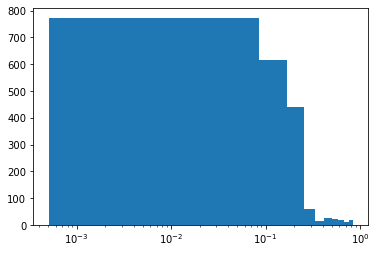

In [310]:
plt.hist(np.array(sfrs).T[0] * 1e9)
plt.xscale('log')

---